In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

2.3.1


In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']

In [4]:
raw_dataset = pd.read_csv(url, names=column_names,
                         na_values='?', comment='\t',
                         sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [11]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [12]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

In [13]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [14]:
train_ds = dataset.sample(frac=0.8, random_state=0)

In [15]:
test_ds = dataset.drop(train_ds.index)

In [16]:
train_ft = train_ds.copy()
test_ft = test_ds.copy()

train_labels = train_ft.pop('MPG')
test_labels = test_ft.pop('MPG')

In [17]:
normalizer = preprocessing.Normalization()

In [18]:
normalizer.adapt(np.array(train_ft))

In [19]:
print(normalizer.mean.numpy)

<bound method BaseResourceVariable.numpy of <tf.Variable 'mean:0' shape=(9,) dtype=float32, numpy=
array([   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
          0.178,    0.197,    0.624], dtype=float32)>>


In [22]:
dnn_model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [23]:
dnn_model.compile(loss='mean_absolute_error',
                 optimizer='adam')

In [24]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [25]:
history = dnn_model.fit(
            train_ft,
            train_labels,
            validation_split=0.2,
            verbose=0,
            epochs=100)

In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

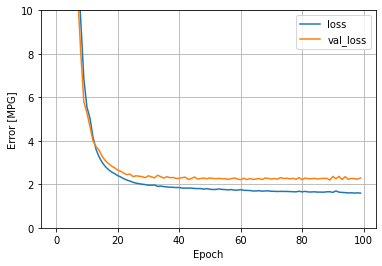

In [28]:
plot_loss(history)

In [29]:
test_predictions = dnn_model.predict(test_ft).flatten()

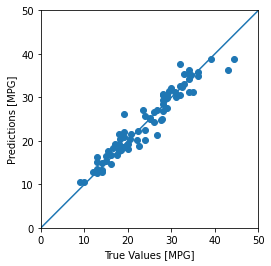

In [30]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)